# MODULE 3: CT Image segmentation and classification
### Exercise 3.1: Image segmentation

In [ ]:
# setting for running at colab
# !git clone https://<username>:<token>@gitlab.developers.cam.ac.uk/phy/data-intensive-science-mphil/assessments/a2_coursework/yi260.git
# %cd yi260/main
# ! pwd
# ! pip install SimpleITK sklearn.metrics

In [5]:
# Open and save .nii files to numpy arrays
import os
import numpy as np
import SimpleITK as sitk

indir = "./Data/Module3/nii/"
outdir = "./Data/Module3/npy/"
os.makedirs(outdir, exist_ok=True)

def load_nifti(filepath):
    img = sitk.ReadImage(filepath)
    arr = sitk.GetArrayFromImage(img)  # Shape: (z, y, x)
    return arr

def crop_with_margin(img, mask, margin_xy=30, margin_z=5):
    indices = np.argwhere(mask == 1)
    if len(indices) == 0:
        return None

    zmin, ymin, xmin = np.min(indices, axis=0)
    zmax, ymax, xmax = np.max(indices, axis=0)

    # Ensure cropping stays within bounds
    zmin = max(zmin - margin_z, 0)
    zmax = min(zmax + margin_z, img.shape[0])
    ymin = max(ymin - margin_xy, 0)
    ymax = min(ymax + margin_xy, img.shape[1])
    xmin = max(xmin - margin_xy, 0)
    xmax = min(xmax + margin_xy, img.shape[2])

    return img[zmin:zmax, ymin:ymax, xmin:xmax], mask[zmin:zmax, ymin:ymax, xmin:xmax]

# Loop through files
for filename in os.listdir(indir):
    if filename.endswith("_mask.nii"):
        case_base = filename.replace("_mask.nii", "")
        img_path = os.path.join(indir, f"{case_base}.nii")
        mask_path = os.path.join(indir, filename)

        if not os.path.exists(img_path):
            continue

        # Load image and mask
        img = load_nifti(img_path)
        mask = load_nifti(mask_path)

        if img.shape != mask.shape:
            print(f"Shape mismatch: {case_base}")
            continue

        result = crop_with_margin(img, mask)
        if result is None:
            print(f"No tumor found in {case_base}")
            continue

        img_crop, mask_crop = result

        # Save cropped arrays
        np.save(os.path.join(outdir, f"{case_base}.npy"), img_crop)
        np.save(os.path.join(outdir, f"{case_base}_mask.npy"), mask_crop)
        print(f"Cropped and saved: {case_base}")


Cropped and saved: case_31
Cropped and saved: case_0
Cropped and saved: case_2
Cropped and saved: case_16
Cropped and saved: case_13
Cropped and saved: case_10
Cropped and saved: case_12
Cropped and saved: case_9
Cropped and saved: case_34
Cropped and saved: case_21
Cropped and saved: case_1
Cropped and saved: case_19
Cropped and saved: case_27
Cropped and saved: case_20
Cropped and saved: case_18
Cropped and saved: case_33
Cropped and saved: case_15
Cropped and saved: case_22
Cropped and saved: case_4
Cropped and saved: case_29
Cropped and saved: case_11
Cropped and saved: case_17
Cropped and saved: case_28
Cropped and saved: case_35
Cropped and saved: case_7
Cropped and saved: case_36
Cropped and saved: case_24
Cropped and saved: case_3
Cropped and saved: case_6
Cropped and saved: case_5
Cropped and saved: case_25
Cropped and saved: case_14
Cropped and saved: case_30
Cropped and saved: case_8
Cropped and saved: case_23
Cropped and saved: case_26


[case_12]  Tumor voxel stats:
  Tumor - Min: -418.00, Max: 51.00, Mean: -145.66, Std: 137.59
  Non-tumor - Min: -1003.00, Max: 3071.00, Mean: -720.28, Std: 295.84


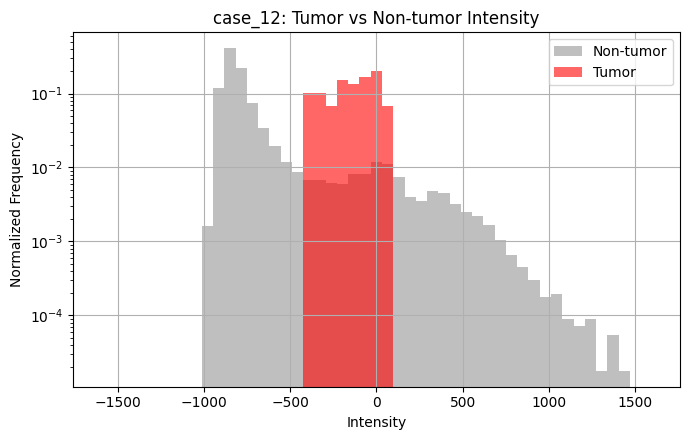

[case_2]  Tumor voxel stats:
  Tumor - Min: -435.00, Max: 115.00, Mean: 7.15, Std: 47.64
  Non-tumor - Min: -1015.00, Max: 1423.00, Mean: -515.85, Std: 439.73


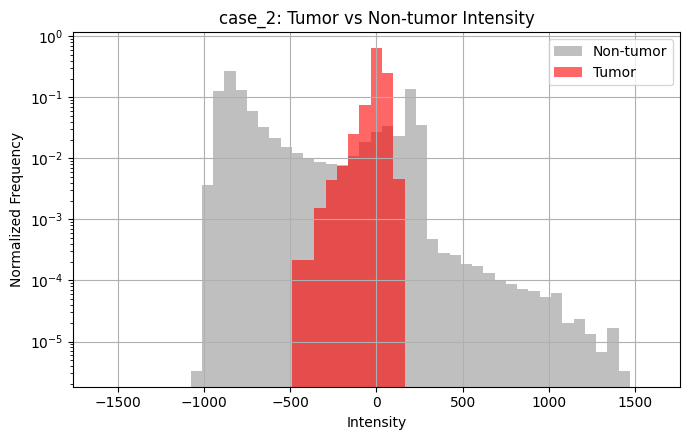

[case_22]  Tumor voxel stats:
  Tumor - Min: -1024.00, Max: 768.00, Mean: -90.36, Std: 269.70
  Non-tumor - Min: -1024.00, Max: 2045.00, Mean: -545.98, Std: 471.17


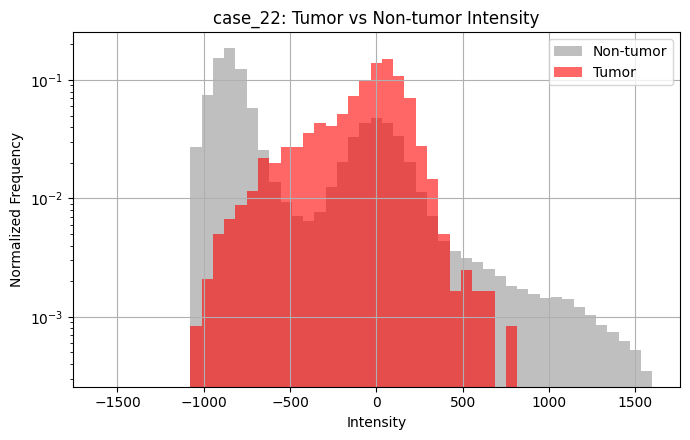

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

outdir = "./Data/Module3/npy/"
invalid_value = -3024

# Find all case images
image_files = sorted(glob.glob(os.path.join(outdir, "case_*2.npy"))) # 2, 12, and 22 cases as examples.
image_files = [f for f in image_files if not f.endswith("_mask.npy")]

for img_path in image_files:
    case_id = os.path.basename(img_path).replace(".npy", "")
    mask_path = os.path.join(outdir, case_id + "_mask.npy")

    if not os.path.exists(mask_path):
        print(f"[{case_id}]  No corresponding mask file. Skipping.")
        continue

    # Load image and mask
    img = np.load(img_path)
    mask = np.load(mask_path)

    if img.shape != mask.shape:
        print(f"[{case_id}]  Shape mismatch. Skipping.")
        continue

    # Filter out invalid background voxels
    tumor_voxels = img[(mask == 1) & (img != invalid_value)].astype(np.float32)
    normal_voxels = img[(mask == 0) & (img != invalid_value)].astype(np.float32)

    if tumor_voxels.size == 0:
        print(f"[{case_id}]  No tumor voxels. Skipping plot.")
        continue

    print(f"[{case_id}]  Tumor voxel stats:")
    print(f"  Tumor - Min: {tumor_voxels.min():.2f}, Max: {tumor_voxels.max():.2f}, "
          f"Mean: {tumor_voxels.mean():.2f}, Std: {tumor_voxels.std():.2f}")
    print(f"  Non-tumor - Min: {normal_voxels.min():.2f}, Max: {normal_voxels.max():.2f}, "
          f"Mean: {normal_voxels.mean():.2f}, Std: {normal_voxels.std():.2f}")

    # Plot histogram
    plt.figure(figsize=(7, 4.5))
    bins = np.linspace(-1600, 1600, 50)

    plt.hist(normal_voxels, bins=bins, color='gray', alpha=0.5,
             label='Non-tumor', weights=np.ones_like(normal_voxels) / normal_voxels.size)

    plt.hist(tumor_voxels, bins=bins, color='red', alpha=0.6,
             label='Tumor', weights=np.ones_like(tumor_voxels) / tumor_voxels.size)

    plt.yscale('log')
    plt.xlabel("Intensity")
    plt.ylabel("Normalized Frequency")
    plt.title(f"{case_id}: Tumor vs Non-tumor Intensity")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

outdir = "./Data/Module3/npy/"
invalid_value = -3024

def threshold_classifier(image, valid_mask=None, lower=-50, upper=100):
    prediction = (image >= lower) & (image <= upper)
    if valid_mask is not None:
        prediction = prediction & valid_mask
    return prediction.astype(np.uint8)

def evaluate_prediction(pred, true, mask=None):
    if mask is not None:
        pred = pred[mask]
        true = true[mask]
    
    precision = precision_score(true, pred, zero_division=0)
    recall = recall_score(true, pred, zero_division=0)
    f1 = f1_score(true, pred, zero_division=0)
    cm = confusion_matrix(true, pred)
    
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "cm": cm
    }

all_true = []
all_pred = []

summary = []

for img_path in image_files:
    case_id = os.path.basename(img_path).replace(".npy", "")
    mask_path = os.path.join(outdir, case_id + "_mask.npy")

    if not os.path.exists(mask_path):
        print(f"[{case_id}] Mask not found. Skipping.")
        continue

    img = np.load(img_path)
    mask = np.load(mask_path)
    if img.shape != mask.shape:
        print(f"[{case_id}] Shape mismatch. Skipping.")
        continue

    valid_mask = img != invalid_value
    tumor_voxels = img[(mask == 1) & valid_mask]
    if tumor_voxels.size == 0:
        print(f"[{case_id}] No tumor voxels found. Skipping.")
        continue

    lower = tumor_voxels.min()
    upper = tumor_voxels.max()

    pred = threshold_classifier(img, valid_mask=valid_mask, lower=lower, upper=upper)
    result = evaluate_prediction(pred, mask, mask=valid_mask)

    # Flatten and collect for global confusion matrix
    all_pred.extend(pred[valid_mask].flatten())
    all_true.extend(mask[valid_mask].flatten())

    summary.append({
        "case_id": case_id,
        "lower": lower,
        "upper": upper,
        "precision": result["precision"],
        "recall": result["recall"],
        "f1": result["f1"],
        "confusion_matrix": result["cm"]
    })

# === Per-case Summary ===
df = pd.DataFrame(summary)
print("\n=== Per-Case Summary Table ===")
print(df[["case_id", "lower", "upper", "precision", "recall", "f1"]].to_string(index=False))

# === Global Confusion Matrix ===
global_cm = confusion_matrix(all_true, all_pred)
tn, fp, fn, tp = global_cm.ravel()

print("\n=== Global Confusion Matrix ===")
print(global_cm)
print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")

# === Average Metrics ===
mean_precision = df["precision"].mean()
mean_recall    = df["recall"].mean()
mean_f1        = df["f1"].mean()

print("\n=== Average Metrics Across All Cases ===")
print(f"  Avg False Positive rate: {1.0 - mean_precision:.6f}")
print(f"  Avg False Negative rate:    {1.0 - mean_recall:.6f}")
print(f"  Avg F1 Score:  {mean_f1:.6f}")



=== Per-Case Summary Table ===
case_id  lower  upper  precision  recall       f1
case_12   -418     51   0.018159     1.0 0.035671
 case_2   -435    115   0.102664     1.0 0.186211
case_22  -1024    768   0.011032     1.0 0.021824

=== Global Confusion Matrix ===
[[315391 258291]
 [     0   7012]]
TN=315391, FP=258291, FN=0, TP=7012

=== Average Metrics Across All Cases ===
  Avg False Positive rate: 0.956048
  Avg False Negative rate:    0.000000
  Avg F1 Score:  0.081235


Exercise 3.2: Image feature extraction and classification

In [8]:
import numpy as np
import pandas as pd
import os
import glob

def extract_histogram_features(voxels, n_bins=100):
    if len(voxels) == 0:
        return np.nan, np.nan, np.nan

    # Energy
    energy = np.sum(voxels**2)

    # Mean Absolute Deviation (MAD)
    mean_val = np.mean(voxels)
    mad = np.mean(np.abs(voxels - mean_val))

    # Uniformity
    hist, _ = np.histogram(voxels, bins=n_bins, density=False)
    p = hist / np.sum(hist)
    uniformity = np.sum(p**2)

    return energy, mad, uniformity

# === Parameters ===
data_dir = "./Data/Module3/npy/"
label_csv = "./Data/Module3/labels.csv"
invalid_val = -3024

# === Load and process clinical labels ===
labels_df = pd.read_csv(label_csv)
labels_df["case_id"] = labels_df["ID"].astype(str).apply(lambda x: f"case_{x}")
labels_df["label"] = labels_df["Diagnosis"].apply(lambda x: 0 if x == 1 else 1)

# === Loop over all segmented cases ===
summary = []

for _, row in labels_df.iterrows():
    case_id = row["case_id"]
    label = row["label"]

    img_path = os.path.join(data_dir, f"{case_id}.npy")
    mask_path = os.path.join(data_dir, f"{case_id}_mask.npy")

    if not os.path.exists(img_path) or not os.path.exists(mask_path):
        continue

    img = np.load(img_path)
    mask = np.load(mask_path)

    if img.shape != mask.shape:
        print(f"[{case_id}] Shape mismatch.")
        continue

    tumor_voxels = img[(mask == 1) & (img != invalid_val)].astype(np.int16)

    energy, mad, uniformity = extract_histogram_features(tumor_voxels, n_bins=50)

    summary.append({
        "case_id": case_id,
        "energy": energy,
        "mad": mad,
        "uniformity": uniformity,
        "label": label
    })

# === Create and show final feature table ===
features_df = pd.DataFrame(summary)
# === Save features to file ===
output_csv = "./Data/Module3/radiomic_features.csv"
features_df.to_csv(output_csv, index=False)
print(f"\n Features saved to: {output_csv}")


print("\n Extracted Radiomic Features:")
print(features_df.head())



 Features saved to: ./Data/Module3/radiomic_features.csv

 Extracted Radiomic Features:
  case_id    energy         mad  uniformity  label
0  case_0    279685  189.503849    0.029165      1
1  case_1  12818245  106.039925    0.073780      1
2  case_2   7020660   30.289575    0.104192      1
3  case_3    314104  197.117147    0.029626      0
4  case_4     71962  122.899089    0.029995      1


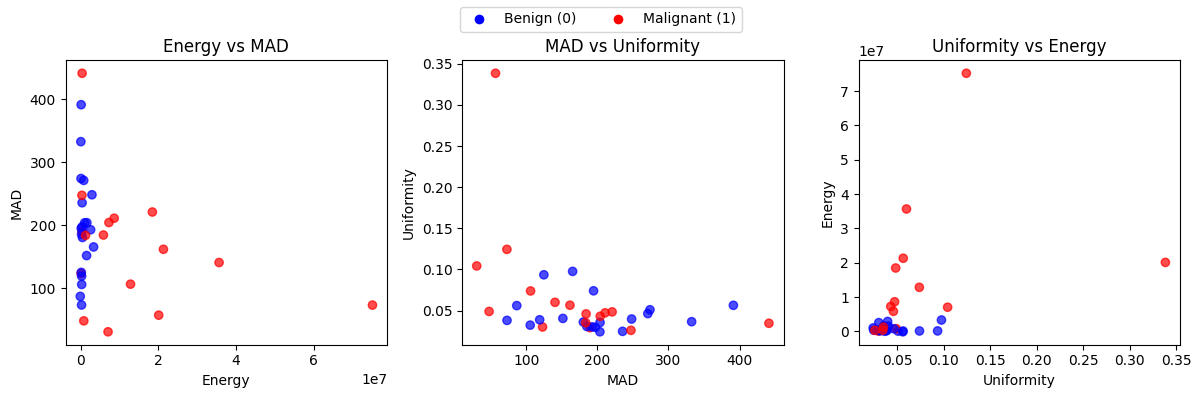

In [9]:
import matplotlib.pyplot as plt

# Define colors for labels
label_colors = {0: "blue", 1: "red"}
colors = features_df["label"].map(label_colors)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot 1: Energy vs MAD
axes[0].scatter(features_df["energy"], features_df["mad"], c=colors, alpha=0.7)
axes[0].set_title("Energy vs MAD")
axes[0].set_xlabel("Energy")
axes[0].set_ylabel("MAD")

# Plot 2: MAD vs Uniformity
axes[1].scatter(features_df["mad"], features_df["uniformity"], c=colors, alpha=0.7)
axes[1].set_title("MAD vs Uniformity")
axes[1].set_xlabel("MAD")
axes[1].set_ylabel("Uniformity")

# Plot 3: Uniformity vs Energy
axes[2].scatter(features_df["uniformity"], features_df["energy"], c=colors, alpha=0.7)
axes[2].set_title("Uniformity vs Energy")
axes[2].set_xlabel("Uniformity")
axes[2].set_ylabel("Energy")

# Add legend
legend_handles = [
    plt.Line2D([0], [0], marker='o', color='w', label='Benign (0)', markerfacecolor='blue', markersize=8),
    plt.Line2D([0], [0], marker='o', color='w', label='Malignant (1)', markerfacecolor='red', markersize=8)
]
fig.legend(handles=legend_handles, loc='upper center', ncol=2)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [10]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# === Features and label ===
X = features_df[["mad", "uniformity", "energy"]].values
y = features_df["label"].values

# === Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Fit logistic regression ===
model = LogisticRegression()
model.fit(X_train, y_train)

# === Predict and evaluate ===
y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\n Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# === Optional: check coefficients ===
coef_df = pd.DataFrame({
    "Feature": ["mad", "uniformity", "energy"],
    "Coefficient": model.coef_[0]
})
print("\n Model Coefficients:")
print(coef_df)


Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.67      0.80         3

    accuracy                           0.88         8
   macro avg       0.92      0.83      0.85         8
weighted avg       0.90      0.88      0.87         8


 Confusion Matrix:
[[5 0]
 [1 2]]

 Model Coefficients:
      Feature   Coefficient
0         mad  1.763380e-04
1  uniformity -1.359559e-01
2      energy  4.323338e-07
